In [3]:
# import packages for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os

In [51]:
from src.fasta_utilities import get_TF_fasta

get_TF_fasta() # obtain the TF fasta file

In [52]:
from src import fldpnn2_scores
fldpnn2_scores.get_scores()

,ID,fldpnn2_score
0,A0A0K3AR10,"0.316,0.332,0.322,0.339,0.328,0.31,0.299,0.331..."
1,A0A0K3ARK1,"0.392,0.414,0.472,0.471,0.485,0.452,0.465,0.47..."
2,A0A0K3ATY3,"0.392,0.42,0.467,0.464,0.478,0.458,0.458,0.447..."
3,A0A0K3AUK7,"0.262,0.261,0.281,0.393,0.437,0.395,0.344,0.30..."
4,A0A0K3AWW5,"0.193,0.173,0.184,0.171,0.183,0.195,0.206,0.20..."
5,A0A486WW91,"0.401,0.525,0.561,0.637,0.42,0.362,0.362,0.362..."
6,A0A486WWS1,"0.383,0.509,0.598,0.734,0.598,0.464,0.379,0.51..."
7,A0A5S9MQ08,"0.316,0.332,0.322,0.339,0.327,0.31,0.299,0.331..."
8,B6VQ92,"0.42,0.392,0.347,0.37,0.349,0.335,0.323,0.357,..."


In [ ]:
protein_inf = [
    ('HLH-1', 'P22980'),
    ('ELT-1', 'P28515'),
    ('ELT-2', 'Q10655'),
    ('ELT-3', 'B7WN96'),
    ('PHA-4', 'Q17381'),
    ('HND-1', 'Q18612'),
]
master_gene_names = {
    uniprot_id: gene for (gene, uniprot_id) in protein_inf
}

In [ ]:
path_master_df = 'data/master_tf.csv'
path_master_fasta = 'data/master_tf.fasta'

df_tf = pd.read_csv('data/id_mapping.csv')

tf_of_interest_filt = df_tf.Entry.isin([x[1] for x in protein_inf])

df_tf[tf_of_interest_filt].to_csv(path_master_df, index=False)

from src.fasta_utilities import get_TF_fasta

get_TF_fasta(
    path_master_df,
    path_master_fasta   
) # obtain the TF fasta file


In [35]:
from src import fldpnn2_scores

fldpnn2_master = fldpnn2_scores.get_scores(
    path='data/fldpnn2_master.txt'
)

In [36]:
fldpnn2_master.fldpnn2_score = fldpnn2_master.fldpnn2_score.apply(
    lambda x: [float(s) for s in x.split(',')]
)

In [37]:
master_df = pd.merge(df_tf[tf_of_interest_filt], 
                     fldpnn2_master, 
                     left_on='Entry', 
                     right_on='ID')

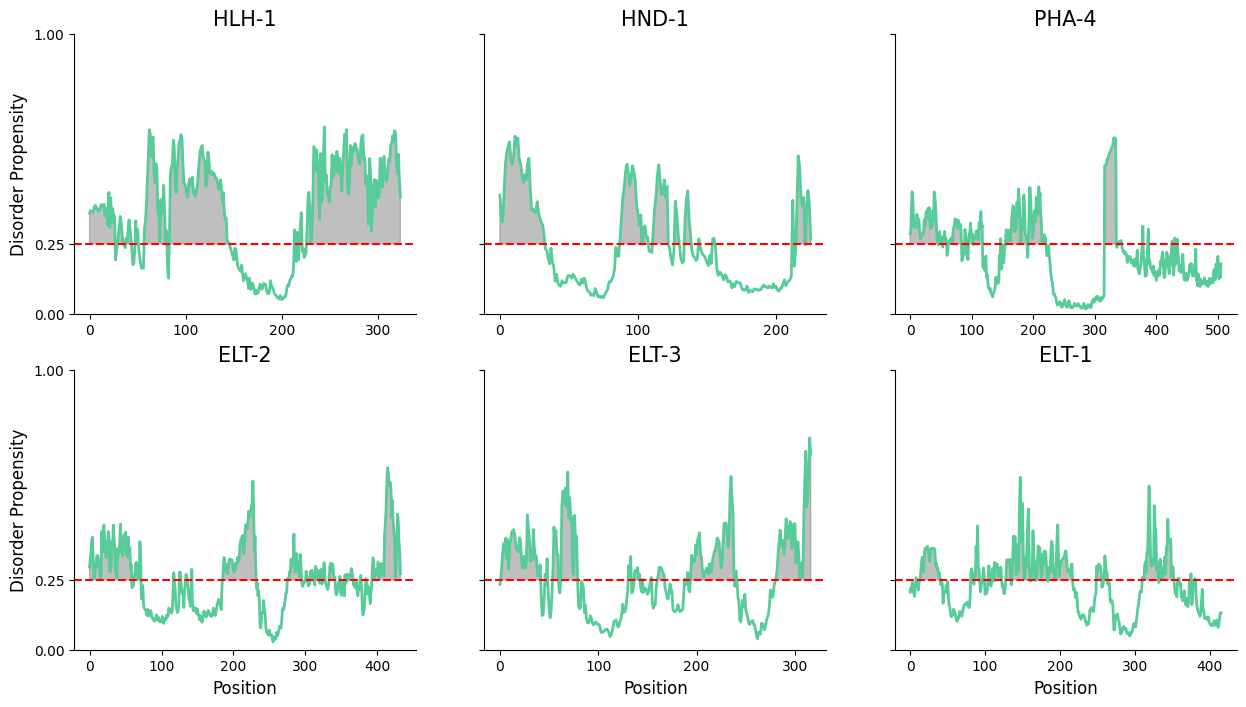

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for axs in axes: 
    axs.spines[['top', 'right']].set_visible(False)

thresh = 0.25

for ax, (i, row) in zip(axes, master_df.iterrows()):
    uniprot_id = row['Entry']
    name = master_gene_names[uniprot_id]
    x = np.arange(len(row['fldpnn2_score']))
    y = np.array(row['fldpnn2_score'])
    ax.plot(x, y, color='#57cc99', linewidth=2)
    ax.axhline(thresh, color='red', linestyle='--', linewidth=1.5)
    ax.fill_between(x, y, thresh, where=(y > thresh), color='grey', alpha=0.5)
    ax.set_title(name, fontsize=15)
    ax.set_yticks([0, thresh, 1])
    ax.set_ylim(0, 1)
    x_ticks = np.arange(0, len(x)+1, 100)
    ax.set_xticks(x_ticks)
    if i >= 3:ax.set_xlabel('Position', fontsize=12)
    if i == 0 or i == 3: ax.set_ylabel('Disorder Propensity', fontsize=12)
    

# plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

def get_scores(path: str = "data/fldpnn2_master.txt") -> pd.DataFrame:
    """
    Reads a txt file from fldpnn2 containing disorder sequences, 
    processes the data, and returns a DataFrame.

    Args:
        path (str, optional): The file path to the disorder sequences data.
                              Defaults to "data/fldpnn2.txt".

    Returns:
        pd.DataFrame: A DataFrame containing two columns:
                      - "ID": The cleaned sequence identifiers.
                      - "fldpnn2_score": The corresponding disorder scores.
    """
    # Initialize an empty dictionary to store sequence IDs and their scores
    fldpnn2_dict: dict = {}

    with open(path, mode="r") as file:

        lines: list = file.readlines()
        
        # header occupies always first 8 lines
        cleaned_lines = [line.strip() for line in lines[8:]]
        
        # Extract sequence IDs and disorder scores:
        # - Sequence IDs are assumed to be every 5th line starting from the first
        # - Disorder scores are assumed to be every 5th line starting from the fifth
        sequence_id = cleaned_lines[0::5]
        idr_ranges = cleaned_lines[1::5]
        aa_sequence = cleaned_lines[2::5]
        is_disordered = cleaned_lines[3::5]
        disorder_scores = cleaned_lines[4::5]
        
        # Create a dictionary mapping each sequence ID to its disorder score
        fldpnn2_dict = {
            name: disorder_seq 
            for name, disorder_seq in zip(sequence_id, disorder_scores)
        }
    print(sequence_id)
    

    df_fldpnn2 = pd.DataFrame(
        fldpnn2_dict.items(), 
        columns=["ID", "fldpnn2_score"]
    )
    
    # clean the sequence identifiers
    df_fldpnn2["ID"] = df_fldpnn2["ID"].str.replace(">", "", regex=False)
    
    return df_fldpnn2

df_fldpnn2 = get_scores()